Dhaivat Jani <br>
202511053

# Data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("fake_reviews_dataset.csv")
df.shape

(40432, 4)

In [3]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [4]:
df['category'].value_counts()

category
Kindle_Store_5                  4730
Books_5                         4370
Pet_Supplies_5                  4254
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3946
Tools_and_Home_Improvement_5    3858
Clothing_Shoes_and_Jewelry_5    3848
Toys_and_Games_5                3794
Movies_and_TV_5                 3588
Name: count, dtype: int64

In [5]:
df['label'].value_counts()

label
CG    20216
OR    20216
Name: count, dtype: int64

# Pre-processing

## Tokenization

In [6]:
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")

def spacy_tokenize(text):
    doc = nlp(text)
    
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.is_alpha and not token.is_stop
    ]
    
    return tokens

In [8]:
df["tokens"] = df["text_"].apply(spacy_tokenize)

In [9]:
df["tokenized_text"] = df["tokens"].apply(lambda x: " ".join(x))

## TF-IDF Vectorization

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(df["tokenized_text"]).toarray()

In [17]:
X.shape

(40432, 5000)

# Label Encoding

In [14]:
from sklearn.preprocessing import LabelEncoder

## For Task 1

In [15]:
category_encoder = LabelEncoder()

y_category = category_encoder.fit_transform(df["category"])

## For Task 2

In [16]:
fake_encoder = LabelEncoder()

y_fake = fake_encoder.fit_transform(df["label"])

# Train-Test Split

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, ycat_train, ycat_test, yfake_train, yfake_test = train_test_split(
    X, y_category, y_fake,
    test_size=0.2,
    random_state=42
)

In [19]:
import torch

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)

ycat_train = torch.tensor(ycat_train, dtype=torch.long)
ycat_test  = torch.tensor(ycat_test, dtype=torch.long)

yfake_train = torch.tensor(yfake_train, dtype=torch.float32)
yfake_test  = torch.tensor(yfake_test, dtype=torch.float32)

In [25]:
X_train.shape

torch.Size([32345, 5000])

In [26]:
X_test.shape

torch.Size([8087, 5000])

# Neural Network

In [20]:
import torch.nn as nn
import torch.optim as optim

In [41]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# Task-1 : Categorical

In [50]:
model_cat_1 = FeedForwardNN(X.shape[1], len(category_encoder.classes_))
cat_loss_fn = nn.CrossEntropyLoss()
cat_optimizer = optim.Adam(model_cat_1.parameters(), lr=0.001)

cat_losses = []

for epoch in range(20):
    cat_optimizer.zero_grad()
    outputs = model_cat_1(X_train)
    loss = cat_loss_fn(outputs, ycat_train)
    loss.backward()
    cat_optimizer.step()
    cat_losses.append(loss.item())

    print(f"Epoch [{epoch+1}/20] - Loss: {loss.item():.6f}")

Epoch [1/20] - Loss: 2.308591
Epoch [2/20] - Loss: 2.306814
Epoch [3/20] - Loss: 2.304986
Epoch [4/20] - Loss: 2.302970
Epoch [5/20] - Loss: 2.300710
Epoch [6/20] - Loss: 2.298198
Epoch [7/20] - Loss: 2.295454
Epoch [8/20] - Loss: 2.292513
Epoch [9/20] - Loss: 2.289409
Epoch [10/20] - Loss: 2.286143
Epoch [11/20] - Loss: 2.282707
Epoch [12/20] - Loss: 2.279093
Epoch [13/20] - Loss: 2.275302
Epoch [14/20] - Loss: 2.271329
Epoch [15/20] - Loss: 2.267167
Epoch [16/20] - Loss: 2.262801
Epoch [17/20] - Loss: 2.258212
Epoch [18/20] - Loss: 2.253381
Epoch [19/20] - Loss: 2.248290
Epoch [20/20] - Loss: 2.242934


In [51]:
with torch.no_grad():
    cat_preds = torch.argmax(model_cat_1(X_test), dim=1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    ycat_test,
    cat_preds,
    target_names=category_encoder.classes_
))

                              precision    recall  f1-score   support

                     Books_5       0.38      0.95      0.54       915
Clothing_Shoes_and_Jewelry_5       0.00      0.00      0.00       746
               Electronics_5       0.99      0.11      0.20       760
          Home_and_Kitchen_5       0.00      0.00      0.00       847
              Kindle_Store_5       0.00      0.00      0.00       971
             Movies_and_TV_5       0.99      0.19      0.32       735
              Pet_Supplies_5       0.15      0.99      0.27       867
       Sports_and_Outdoors_5       0.00      0.00      0.00       802
Tools_and_Home_Improvement_5       0.00      0.00      0.00       711
            Toys_and_Games_5       1.00      0.00      0.00       733

                    accuracy                           0.24      8087
                   macro avg       0.35      0.22      0.13      8087
                weighted avg       0.33      0.24      0.14      8087



c:\Users\dhaiv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dhaiv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dhaiv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

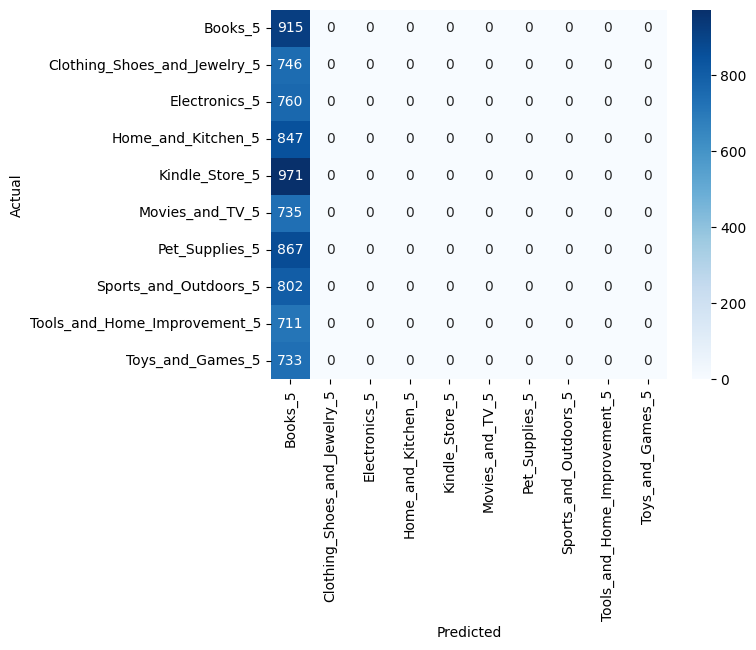

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = category_encoder.classes_ 

cm_cat = confusion_matrix(ycat_test, cat_preds)

sns.heatmap(
    cm_cat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Task -2 : Binary

In [53]:
fake_model = FeedForwardNN(X.shape[1], 1)
fake_loss_fn = nn.BCEWithLogitsLoss()
fake_optimizer = optim.Adam(fake_model.parameters(), lr=0.001)

fake_losses = []

for epoch in range(20):
    fake_optimizer.zero_grad()
    outputs = fake_model(X_train).squeeze()
    loss = fake_loss_fn(outputs, yfake_train)
    loss.backward()
    fake_optimizer.step()
    fake_losses.append(loss.item())

    print(f"Epoch [{epoch+1}/20] - Loss: {loss.item():.6f}")

Epoch [1/20] - Loss: 0.694775
Epoch [2/20] - Loss: 0.693977
Epoch [3/20] - Loss: 0.693097
Epoch [4/20] - Loss: 0.692066
Epoch [5/20] - Loss: 0.690877
Epoch [6/20] - Loss: 0.689541
Epoch [7/20] - Loss: 0.688063
Epoch [8/20] - Loss: 0.686465
Epoch [9/20] - Loss: 0.684775
Epoch [10/20] - Loss: 0.683006
Epoch [11/20] - Loss: 0.681143
Epoch [12/20] - Loss: 0.679166
Epoch [13/20] - Loss: 0.677063
Epoch [14/20] - Loss: 0.674827
Epoch [15/20] - Loss: 0.672467
Epoch [16/20] - Loss: 0.670006
Epoch [17/20] - Loss: 0.667463
Epoch [18/20] - Loss: 0.664844
Epoch [19/20] - Loss: 0.662137
Epoch [20/20] - Loss: 0.659327


In [56]:
with torch.no_grad():
    probs = torch.sigmoid(fake_model(X_test))
    fake_preds = (probs > 0.5).int()

In [57]:
print(classification_report(
    yfake_test,
    fake_preds,
    target_names=fake_encoder.classes_
))

              precision    recall  f1-score   support

          CG       0.86      0.80      0.83      4016
          OR       0.81      0.87      0.84      4071

    accuracy                           0.83      8087
   macro avg       0.84      0.83      0.83      8087
weighted avg       0.84      0.83      0.83      8087



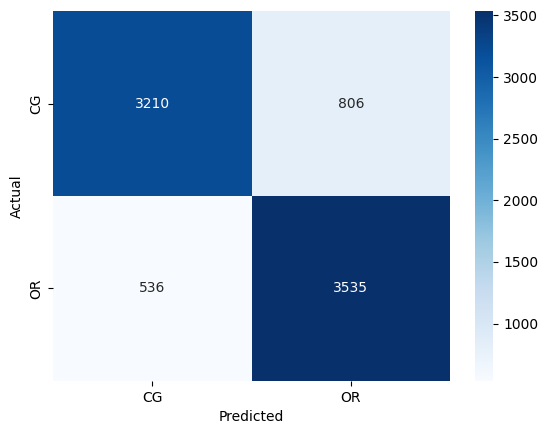

In [65]:
class_names1 = fake_encoder.classes_

cm_fake = confusion_matrix(yfake_test, fake_preds)

sns.heatmap(
    cm_fake,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names1,
    yticklabels=class_names1,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Task-3 : Word Cloud 

## Distribution

In [68]:
fake_label = fake_encoder.transform(["OR"])[0]

fake_reviews = df[y_fake == fake_label]["tokens"]
genuine_reviews = df[y_fake != fake_label]["tokens"]

print(f"Fake reviews count: {len(fake_reviews)}")
print(f"Genuine reviews count: {len(genuine_reviews)}")

Fake reviews count: 20216
Genuine reviews count: 20216


## Category Wise

In [69]:
category_stats = {}

for category in df["category"].unique():
    subset = df[df["category"] == category]
    
    fake_count = (subset["label"] == "OR").sum()
    genuine_count = (subset["label"] == "CG").sum()
    
    category_stats[category] = {
        "Fake": fake_count,
        "Genuine": genuine_count
    }
    
    print(f"Category: {category}")
    print(f"  Fake reviews:     {fake_count}")
    print(f"  Genuine reviews:  {genuine_count}\n")

Category: Home_and_Kitchen_5
  Fake reviews:     2028
  Genuine reviews:  2028

Category: Sports_and_Outdoors_5
  Fake reviews:     1973
  Genuine reviews:  1973

Category: Electronics_5
  Fake reviews:     1994
  Genuine reviews:  1994

Category: Movies_and_TV_5
  Fake reviews:     1794
  Genuine reviews:  1794

Category: Tools_and_Home_Improvement_5
  Fake reviews:     1929
  Genuine reviews:  1929

Category: Pet_Supplies_5
  Fake reviews:     2127
  Genuine reviews:  2127

Category: Kindle_Store_5
  Fake reviews:     2365
  Genuine reviews:  2365

Category: Books_5
  Fake reviews:     2185
  Genuine reviews:  2185

Category: Toys_and_Games_5
  Fake reviews:     1897
  Genuine reviews:  1897

Category: Clothing_Shoes_and_Jewelry_5
  Fake reviews:     1924
  Genuine reviews:  1924



## Wordcloud

In [70]:
from collections import Counter

fake_word_freq = Counter(
    word for tokens in fake_reviews for word in tokens
)

genuine_word_freq = Counter(
    word for tokens in genuine_reviews for word in tokens
)

In [71]:
influential_words = {}

for word, fake_count in fake_word_freq.items():
    genuine_count = genuine_word_freq.get(word, 0)
    
    if fake_count > genuine_count:
        influential_words[word] = fake_count - genuine_count

top_influential = dict(
    sorted(influential_words.items(), key=lambda x: x[1], reverse=True)[:50]
)

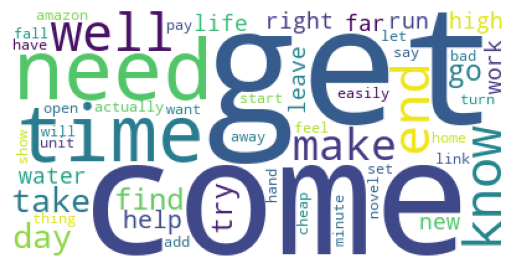

In [76]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    background_color="white",
).generate_from_frequencies(top_influential)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()